In [76]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## CALCULO DE PROBABILIDADES DE ESTADO

In [77]:
# Notar que en cada fila solo van a existir, como máximo, 3 valores no nulos, ya que de un estado solo me puedo mover al estado anterior
# o al siguiente, no puedo saltear ya que son solicitudes encoladas que se procesan de a una, y en una observación (10ms) solo puede 
# ingresar una única solicitud, y/o terminar de procesarse una única solicitud.

# A : Pasar al estado anterior (es decir, cantidad total de solicitudes en el sistema disminuye en 1)
# (No ingresa una nueva solicitud y termina de ser procesada la actual)

# B : Quedarse en el estado actual (es decir, la cantidad total de solicitudes en el sistema sigue igual)
# (No ingresa una nueva solicitud y no termina de ser procesada la actual)
#                               OR
# (Ingresa una nueva solicitud y termina de ser procesada la actual)

# C : Pasar al estado siguiente (es decir, cantidad total de solicitudes en el sistema aumenta en 1)
# (Ingresa una nueva solicitud y no termina de ser procesada la actual)

A = 39/40 * 1/30
B = 39/40 * 29/30 + 1/40 * 1/30
C = 1/40 * 29/30

print("Probabilidad de pasar al estado anterior: ", A)
print("Probabilidad de permanecer en el mismo estado: ", B)
print("Probabilidad de pasar al estado siguiente: ", C)
print("Suma de las probabilidades: ", A + B + C)

Probabilidad de pasar al estado anterior:  0.0325
Probabilidad de permanecer en el mismo estado:  0.9433333333333334
Probabilidad de pasar al estado siguiente:  0.02416666666666667
Suma de las probabilidades:  1.0


## SETEO DE PARAMETROS

In [79]:
# PARAMETROS

MAX_STATES = 30
OBSERVATION_MS = 10
SIMULATION_SECS = 1000
SIMULATION_ITERATIONS = round(SIMULATION_SECS * 1000 / OBSERVATION_MS)
START_STATE = 0  

## CALCULO DE MATRIZ DE TRANSICIÓN DE ESTADOS

In [78]:
def BuildTransitionMatrix(states):
    
    matrix = []
    
    # En el estado 0 (para el caso particular donde hay 0 solicitudes en el sistema) la probabilidad varía.
    row = np.zeros(states)
    row[0] = 39/40 # probabilidad de que no ingrese la primera solicitud y el sistema quede en el mismo estado 0.
    row[1] = 1/40 # probabilidad de que ingrese la primera solicitud y el sistema pase al estado 1.
    matrix.append(row)
    
    if (states > 2):
        
        for i in range(1, states - 1):
            
            # estoy en fila i => solo miro en las celdas de las columnas i-1, i, i+1
            row = np.zeros(states)
            row[i - 1] = A
            row[i] = B
            row[i + 1] = C
            matrix.append(row)
    
    # En el estado máximo (para el caso particular donde el sistema está con la capacidad de solicitudes saturada) la probabilidad varía.
    # Entonces, la probabilidad de quedarse en el mismo estado es la probabilidad de que no termine de procesar la solicitud actual (no pueden
    # ingresar nuevas solicitudes pues la capacidad está saturada) junto a la probabilidad de que termine de procesar la solicitud actual y
    # que en la misma observación ingresa una nueva solicitud.
    row = np.zeros(states)
    row[states - 1] = 29/30 + 1/40 * 1/30
    row[states - 2] = A
    matrix.append(row)
    
    return matrix

def PrintMatrix(matrix):
    for row in matrix:
        for cell in row:
            if(cell > 0):
                print(" " + '\033[1m' + "%.3f" % cell, end='')
            else:
                print(" " + '\033[0m' + "%.2f" % cell, end='')
        print('\n', end='')

In [80]:
matrix = BuildTransitionMatrix(MAX_STATES)
PrintMatrix(matrix)

 0.975 0.025 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.033 0.943 0.024 0.00 0.00 0.00 0.00 0.00 0.00 0.0

## SIMULACION

In [81]:
transition_matrix = np.matrix(matrix)
state_count = np.zeros(MAX_STATES, dtype=int)

current_state = START_STATE
requests_vs_time = []

for i in range(0, SIMULATION_ITERATIONS):
    
    state_count[current_state] += 1
    requests_vs_time.append(current_state)
    p = np.random.rand()
    
    if(current_state == 0):
        if (p > (1 - transition_matrix[current_state, current_state + 1])):
            current_state += 1
            
    elif(current_state == (MAX_STATES - 1)):
        if (p <= transition_matrix[current_state, current_state - 1]):
            current_state -= 1
            
    else:
        if (p <= transition_matrix[current_state, current_state - 1]):
            current_state -= 1
        elif (p > (1 - transition_matrix[current_state, current_state + 1])):
            current_state += 1

## SOLICITUDES VS TIEMPO

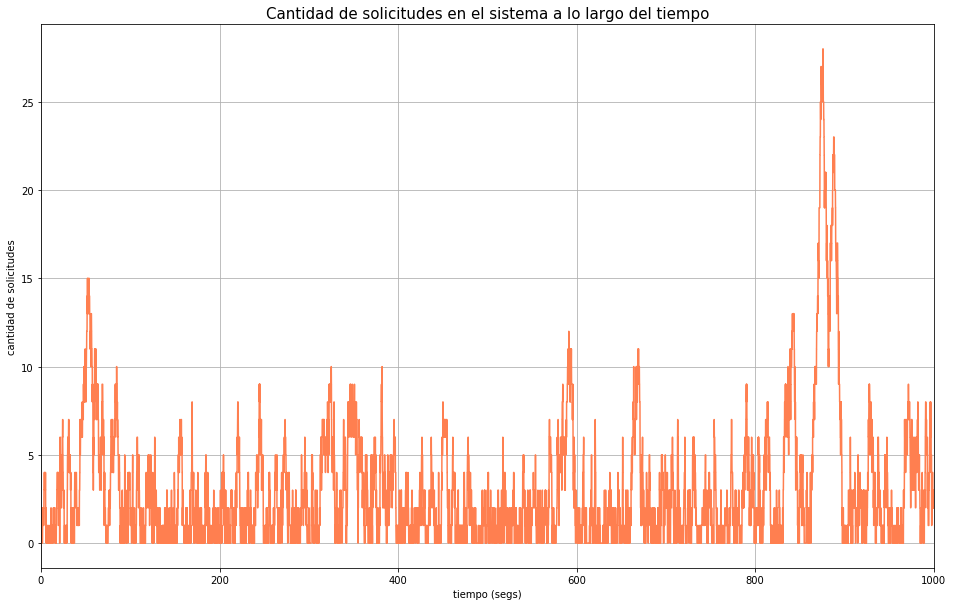

In [89]:
time = []
for i in range(0, SIMULATION_ITERATIONS):
    time.append(i * OBSERVATION_MS / 1000)

plt.figure(figsize=(16,10))
plt.plot(time, requests_vs_time, color='coral')
plt.xlabel('tiempo (segs)')
plt.ylabel('cantidad de solicitudes')
plt.title('Cantidad de solicitudes en el sistema a lo largo del tiempo', fontsize=15)
plt.xlim(0, SIMULATION_SECS)
plt.grid()
plt.show()

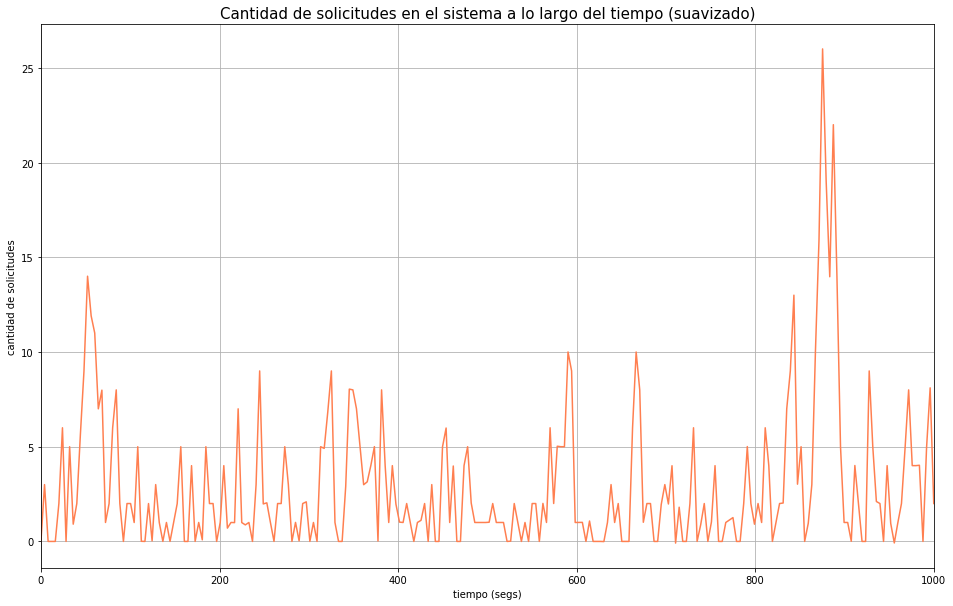

In [83]:
from scipy.interpolate import CubicSpline

xnew = np.linspace(min(time), max(time), round(SIMULATION_SECS / 4))
curve = CubicSpline(time, requests_vs_time)

plt.figure(figsize=(16,10))
plt.plot(xnew, curve(xnew), color='coral')
plt.xlabel('tiempo (segs)')
plt.ylabel('cantidad de solicitudes')
plt.title('Cantidad de solicitudes en el sistema a lo largo del tiempo (suavizado)', fontsize=15)
plt.xlim(0, SIMULATION_SECS)
plt.grid()
plt.show()

## FRECUENCIA DE ESTADOS

In [90]:
pd.set_option('display.max_columns', MAX_STATES)
pd.DataFrame(state_count).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,25764,19830,14719,10041,7388,6070,4432,3406,2099,1638,940,588,322,474,322,183,272,236,113,155,215,122,193,76,72,94,124,65,47,0


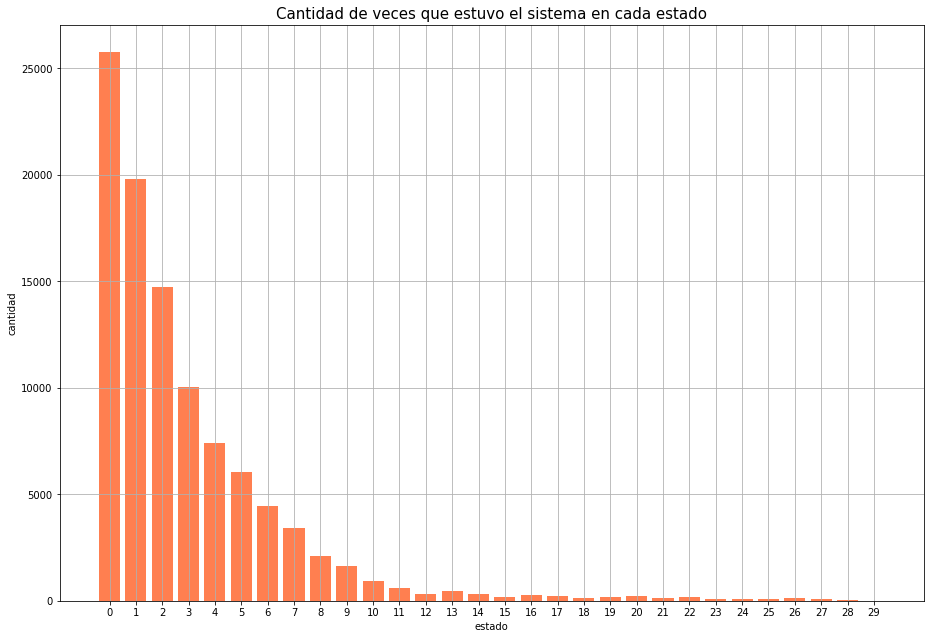

In [85]:
names = []
for i in range (0, MAX_STATES):
    names.append(str(i))

fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(names, state_count, color='coral')
plt.xlabel('estado')
plt.ylabel('cantidad')
plt.title('Cantidad de veces que estuvo el sistema en cada estado', fontsize=15)
plt.grid()
plt.show()

## PORCENTAJE DE INACTIVIDAD

In [86]:
print("Porcentaje de tiempo en el que el sistema estuvo en estado 0 (sin procesar solicitudes): ", (state_count[0] / SIMULATION_ITERATIONS * 100), "%")

Porcentaje de tiempo en el que el sistema estuvo en estado 0 (sin procesar solicitudes):  25.764 %
